In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import minmax_scale

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
loc_gdf = gpd.read_file('data/AQMS_loc.shp')

# Initialise

In [ ]:
# Read in all the data

AQMS_df = pd.read_csv('data/hourly.csv')
Rd_gdf = gpd.read_file('data/london_Road.shp')
Gsp_gdf = gpd.read_file('data/LD_GreenSpace.shp')

cond = pd.read_csv('data/cond_hourly.csv')

In [ ]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf = loc_gdf.set_index('siteid')
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

In [ ]:
# Get all green spaces
Gsp = Gsp_gdf['geometry'].unary_union

# Get all roads
Rd = Rd_gdf['geometry'].unary_union

In [ ]:
# Set buffer zones for every road (50m)
Rd_gdf['buffer_50m'] = Rd_gdf['geometry'].buffer(50)
# Get all road buffer zones
Rd_buffer = Rd_gdf['buffer_50m'].unary_union

In [ ]:
del Gsp_gdf, Rd_gdf

In [ ]:
# Get all near-road green spaces
nRd_Gsp = Gsp.intersection(Rd_buffer)

In [ ]:
# Get all near-greenspace roads
nRd_Gsp_buffer = nRd_Gsp.buffer(50)
nGsp_Rd = Rd.intersection(nRd_Gsp_buffer)

In [ ]:
del Rd_buffer, nRd_Gsp_buffer

In [ ]:
# store all buffer zones in a list
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site, 'buffer_1km'])

In [ ]:
# get all roads, green spaces, near-road green spaces and near-gsp roads in buffer zones around every sites
Rd_shp = []
Gsp_shp = []
nRd_Gsp_shp = []
nGsp_Rd_shp = []
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
    nGsp_Rd_shp.append(poly.intersection(nGsp_Rd))
print(len(Rd_shp), len(Gsp_shp), len(nRd_Gsp_shp), len(nGsp_Rd_shp))

In [ ]:
del Rd, Gsp, nRd_Gsp, nGsp_Rd

In [ ]:
# append them into the dataframe
loc_gdf['Rd'] = Rd_shp
loc_gdf['Gsp'] = Gsp_shp
loc_gdf['nRd_Gsp'] = nRd_Gsp_shp
loc_gdf['nGsp_Rd'] = nGsp_Rd_shp

# and set their data types to geometry
loc_gdf = loc_gdf.set_geometry('Rd').set_geometry('Gsp').set_geometry('nRd_Gsp').set_geometry('nGsp_Rd')

In [ ]:
del Rd_shp, Gsp_shp, nRd_Gsp_shp, nGsp_Rd_shp

In [ ]:
# london boundary read in
london = gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax = plt.subplots(1, figsize=(15,13))

london.plot(color='lightgrey', ax=ax)
loc_gdf['buffer_1km'].plot(color='silver', ax=ax)
loc_gdf['Gsp'].plot(label='Green space', color='limegreen', ax=ax)
loc_gdf['nRd_Gsp'].plot(label='Near_road green space', color='darkgreen', ax=ax)
loc_gdf['Rd'].plot(color='black', label='Road', linewidth=0.1, ax=ax)
loc_gdf['geometry'].plot(markersize=5, marker='^', color='blue', label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
AQMS_df[AQMS_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='BL0'].Value.values,
                AQMS_df[AQMS_df['Site']=='CD9'].Value.values)

In [ ]:
stats.ttest_rel(AQMS_df[AQMS_df['Site']=='GR4'].Value.values,
                AQMS_df[AQMS_df['Site']=='GB0'].Value.values)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
#loc_gdf.drop(['BL0','GR4'], inplace=True)

In [ ]:
# get total road length in each zone
loc_gdf['Rd_len'] = loc_gdf['Rd'].length

In [ ]:
# get areas of green spaces and percentages of near-road green spaces 
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area
loc_gdf['pct_nRd_Gsp'] = loc_gdf['nRd_Gsp'].area / loc_gdf['Gsp_area'] * 100

In [ ]:
# green space area per road length in each zone
loc_gdf['Gsp_per_Rd_len'] = loc_gdf['Gsp_area'] / loc_gdf['Rd_len']

In [ ]:
# percentage of near-green-space road
loc_gdf['pct_nGsp_Rd'] = loc_gdf['nGsp_Rd'].length / loc_gdf['Rd_len'] * 100

In [ ]:
loc_gdf.info()

In [ ]:
exp_names = loc_gdf.columns[9:].tolist()
exp_names

In [ ]:
loc_gdf[exp_names].hist()

In [ ]:
loc_gdf['log_Gsp_area'] = np.log(loc_gdf['Gsp_area'])
loc_gdf['log_Gsp_area'].hist()

In [ ]:
stats.normaltest(loc_gdf['log_Gsp_area'])

In [ ]:
loc_gdf['log_Gsp_per_Rd_len'] = np.log(loc_gdf['Gsp_per_Rd_len'])
loc_gdf['log_Gsp_per_Rd_len'].hist()

In [ ]:
stats.normaltest(loc_gdf['log_Gsp_per_Rd_len'])

In [ ]:
exp_names[1] = 'log_Gsp_area'
exp_names[3] = 'log_Gsp_per_Rd_len'
exp_names

In [ ]:
# merge PM reading and site geogemetry data
df = pd.merge(AQMS_df, loc_gdf, left_on='Site', right_index=True)
df.info()

In [ ]:
# drop irrelevant columns
df.drop(['sitename', 'buffer_1km', 'Rd', 'Gsp', 'nRd_Gsp', 'nGsp_Rd', 'min_dis'],
        axis=1, inplace=True)
df.info()

In [ ]:
# merge with conditional variables
df = df.merge(cond, on='ReadingDateTime')
df.info()

In [ ]:
cond_names = df.columns[-3:].tolist()
cond_names

In [ ]:
df[exp_names + cond_names].describe()

In [ ]:
df.to_csv('temp_data.csv', index=False)

# Temporarily save

In [4]:
df = pd.read_csv('temp_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Site                183960 non-null  object 
 1   ReadingDateTime     183960 non-null  object 
 2   Value               183960 non-null  float64
 3   geometry            183960 non-null  object 
 4   Rd_len              183960 non-null  float64
 5   Gsp_area            183960 non-null  float64
 6   pct_nRd_Gsp         183960 non-null  float64
 7   Gsp_per_Rd_len      183960 non-null  float64
 8   pct_nGsp_Rd         183960 non-null  float64
 9   log_Gsp_area        183960 non-null  float64
 10  log_Gsp_per_Rd_len  183960 non-null  float64
 11  bp_mean             183960 non-null  float64
 12  tmp_mean            183960 non-null  float64
 13  rh_mean             183960 non-null  float64
dtypes: float64(11), object(3)
memory usage: 19.6+ MB


In [6]:
df.drop('geometry', axis=1, inplace=True)

In [7]:
# covert the DateTime column to numpy.datetime variable
df['ReadingDateTime'] = pd.to_datetime(df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Site                183960 non-null  object        
 1   DateTime            183960 non-null  datetime64[ns]
 2   Value               183960 non-null  float64       
 3   Rd_len              183960 non-null  float64       
 4   Gsp_area            183960 non-null  float64       
 5   pct_nRd_Gsp         183960 non-null  float64       
 6   Gsp_per_Rd_len      183960 non-null  float64       
 7   pct_nGsp_Rd         183960 non-null  float64       
 8   log_Gsp_area        183960 non-null  float64       
 9   log_Gsp_per_Rd_len  183960 non-null  float64       
 10  bp_mean             183960 non-null  float64       
 11  tmp_mean            183960 non-null  float64       
 12  rh_mean             183960 non-null  float64       
dtypes: datetime64[ns](1), float64

In [13]:
exp_names = df.columns[3:8].tolist()
exp_names[1] = 'log_Gsp_area'
exp_names[3] = 'log_Gsp_per_Rd_len'
exp_names

['Rd_len', 'log_Gsp_area', 'pct_nRd_Gsp', 'log_Gsp_per_Rd_len', 'pct_nGsp_Rd']

In [10]:
cond_names = df.columns[-3:].tolist()

In [11]:
loc_gdf = loc_gdf.set_index('siteid')

In [14]:
loc_gdf = pd.merge(df.groupby('Site').mean()[exp_names], loc_gdf, left_index=True, right_index=True)

In [15]:
loc_gdf.head()

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_Gsp_per_Rd_len,pct_nGsp_Rd,sitename,geometry
BL0,66247.190928,12.003627,81.737073,0.902478,21.354334,Camden - Bloomsbury,POINT (530120.048 182038.807)
BX9,36565.805888,12.183765,36.347259,1.676897,12.244855,Bexley - Slade Green FDMS,POINT (551862.205 176375.976)
CD1,51527.369854,11.607442,35.248018,0.757574,9.316740,Camden - Swiss Cottage,POINT (526629.730 184391.024)
CD9,60641.160028,12.018009,80.469155,1.005280,26.669388,Camden - Euston Road,POINT (529900.870 182666.124)
CR8,47234.530733,12.899817,30.294727,2.136936,16.706190,Croydon - Norbury Manor,POINT (530322.972 169553.770)


In [16]:
df.groupby('Site').mean()[exp_names]

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_Gsp_per_Rd_len,pct_nGsp_Rd
Site,,,,,
BL0,66247.190928,12.003627,81.737073,0.902478,21.354334
BX9,36565.805888,12.183765,36.347259,1.676897,12.244855
CD1,51527.369854,11.607442,35.248018,0.757574,9.316740
CD9,60641.160028,12.018009,80.469155,1.005280,26.669388
CR8,47234.530733,12.899817,30.294727,2.136936,16.706190
CT2,54095.918801,11.288076,76.940177,0.389562,15.328578
CT3,57539.222195,10.824925,94.958109,-0.135297,16.003498
GB0,47599.318316,12.805253,50.089698,2.034680,17.220875
GN3,45680.266552,12.952773,59.923776,2.223351,23.452222


In [17]:
# kernel weight matrix for the sites
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [19]:
for var in exp_names:
    moran_temp = Moran(loc_gdf[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for Rd_len is  0.23493  p-value:  0.0
Global Moran's I for log_Gsp_area is  0.12411  p-value:  0.00297
Global Moran's I for pct_nRd_Gsp is  0.11296  p-value:  0.00543
Global Moran's I for log_Gsp_per_Rd_len is  0.17298  p-value:  0.00014
Global Moran's I for pct_nGsp_Rd is  0.06421  p-value:  0.05133


<AxesSubplot:xlabel='hour'>

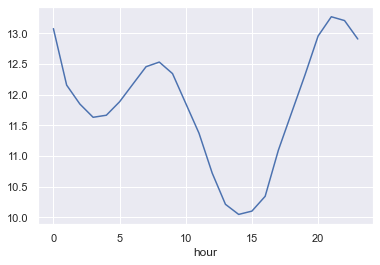

In [20]:
df['hour'] = df['DateTime'].dt.hour
df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

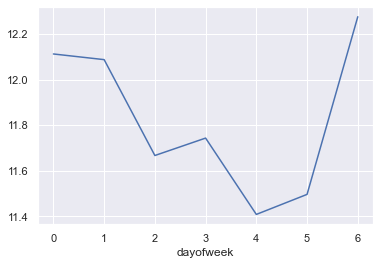

In [21]:
df['dayofweek'] = df['DateTime'].dt.dayofweek
df.groupby('dayofweek').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofmonth'>

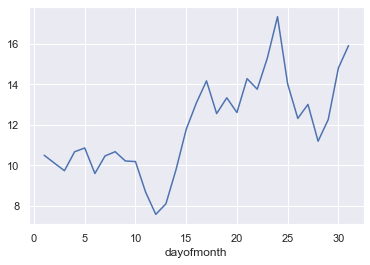

In [22]:
df['dayofmonth'] = df['DateTime'].dt.day
df.groupby('dayofmonth').mean()['Value'].plot()

In [23]:
def get_importance(reg, features, target, feature_names, rep=50):
    mean = []
    std = []
    importance = permutation_importance(reg, features, target, n_repeats=rep, random_state=25)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [24]:
def get_cv_score(reg, features, target, iter=100, split=10, method='r2'):
    score = []
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf, scoring=method).tolist()
        score = score + cv
    
    return (np.mean(score), np.std(score))

In [25]:
reg = LinearRegression()
var = exp_names + cond_names

ap_X = df[var].values
ap_y = df['Value'].values

reg.fit(ap_X, ap_y)

get_importance(reg, ap_X, ap_y, var)

([0.00501, 0.00786, 0.017, 0.05221, 0.0077, 0.08188, 0.04127, 0.00063],
 [0.00024, 0.00027, 0.00042, 0.00075, 0.00026, 0.00101, 0.00064, 8e-05])

In [26]:
get_cv_score(reg, ap_X, ap_y)

(0.0654378224673473, 0.006992503773368277)

In [27]:
h_fi = []
h_cv = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,var].values
    y = df[df['hour']==hour].loc[:,'Value'].values
    reg.fit(X, y)
    
    fi_mean, fi_std = get_importance(reg, X, y, feature_names=var)
    h_fi.append(fi_mean + fi_std)
    
    r2 = list(get_cv_score(reg, X, y))
    mse = list(get_cv_score(reg, X, y, method='neg_mean_squared_error'))
    h_cv.append(r2 + mse)
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
h_fi = pd.DataFrame(h_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
h_cv = pd.DataFrame(h_cv, columns=['r2', 'r2_std', 'mse', 'mse_std'])
h_coef = pd.DataFrame(h_coef, columns=var+['intercept'])

In [28]:
h_reg = pd.concat([h_coef, h_cv, h_fi], axis=1)
h_reg

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,intercept,r2,...,fi_tmp_mean,fi_rh_mean,fi_std_Rd_len,fi_std_log_Gsp_area,fi_std_pct_nRd_Gsp,fi_std_log_Gsp_per_Rd_len,fi_std_pct_nGsp_Rd,fi_std_bp_mean,fi_std_tmp_mean,fi_std_rh_mean
0,0.000056,-4.310861,0.120676,5.768254,-0.228105,0.202783,-0.530646,0.116184,-156.772564,0.103179,...,0.07984,0.01052,0.00122,0.00751,0.00496,0.01138,0.00262,0.00486,0.00419,0.00178
1,0.000002,-0.180193,0.040572,1.078945,-0.077642,0.196386,-0.483837,0.172304,-196.541846,0.095518,...,0.07240,0.02486,0.00004,0.00031,0.00181,0.00227,0.00100,0.00484,0.00388,0.00237
2,-0.000051,1.908643,0.045397,-0.973274,-0.079930,0.192388,-0.484688,0.213033,-216.828960,0.097690,...,0.06955,0.03614,0.00122,0.00292,0.00186,0.00187,0.00091,0.00451,0.00368,0.00273
3,-0.000044,1.566480,0.043078,-0.715873,-0.073108,0.182571,-0.479667,0.251145,-207.377504,0.098579,...,0.06077,0.04300,0.00103,0.00242,0.00161,0.00135,0.00090,0.00384,0.00335,0.00333
4,-0.000049,2.054426,0.041761,-1.185741,-0.074659,0.172279,-0.495817,0.286448,-205.096201,0.119027,...,0.08164,0.06835,0.00115,0.00343,0.00171,0.00248,0.00090,0.00359,0.00377,0.00396
5,-0.000027,1.226050,0.039035,-0.492982,-0.071415,0.186719,-0.433745,0.294936,-212.373773,0.130425,...,0.06988,0.08147,0.00061,0.00207,0.00166,0.00102,0.00080,0.00385,0.00332,0.00446
6,0.000044,-1.251513,0.029843,1.864296,-0.074746,0.210828,-0.314711,0.211586,-205.335924,0.114425,...,0.04311,0.05601,0.00101,0.00231,0.00138,0.00389,0.00090,0.00445,0.00283,0.00369
7,0.000101,-3.134693,0.018493,3.487119,-0.050288,0.205079,-0.254767,0.074968,-169.394079,0.075475,...,0.03275,0.01073,0.00222,0.00620,0.00079,0.00737,0.00060,0.00453,0.00270,0.00178
8,0.000111,-3.154320,0.032095,3.828897,-0.087173,0.196235,-0.200363,0.033989,-157.995899,0.058906,...,0.01674,0.00249,0.00217,0.00498,0.00111,0.00727,0.00107,0.00435,0.00174,0.00082
9,0.000167,-5.630038,0.043534,6.251826,-0.109645,0.189381,-0.184783,0.020541,-126.264457,0.057189,...,0.01937,0.00159,0.00451,0.01063,0.00180,0.01378,0.00142,0.00438,0.00196,0.00060


In [ ]:
h_reg.loc[0,['fi_' + elem for elem in var]]

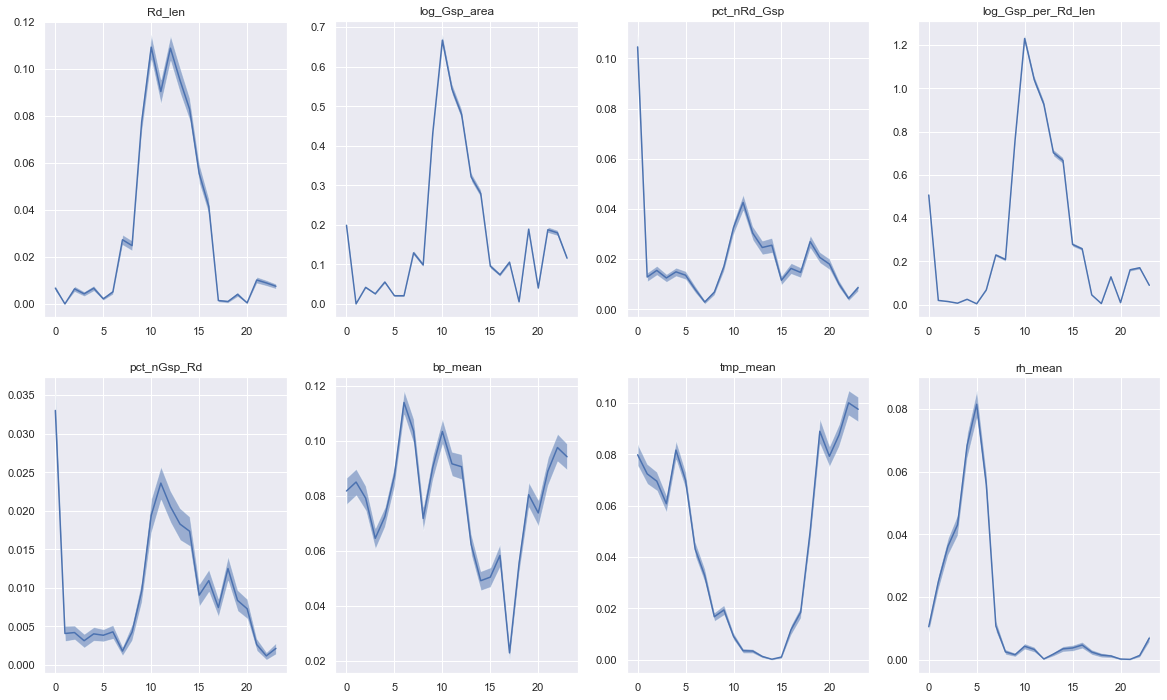

In [29]:
fig, ax = plt.subplots(2,4,figsize=(20,12))
i = 0
for elem in var:
    sns.lineplot(x=range(24), y=h_reg['fi_'+elem].values, ax=ax[i//4,i%4], legend=True)
    ax[i//4,i%4].set_title(elem)
    ax[i//4,i%4].fill_between(x=range(24), y1=h_reg['fi_'+elem].values-h_reg['fi_std_'+elem].values,
                              y2=h_reg['fi_'+elem].values+h_reg['fi_std_'+elem].values, alpha=.5)
    i+=1
plt.show()

In [30]:
# set up a new column for month information
df['month'] = df['DateTime'].dt.month

In [31]:
m_fi = []
m_cv = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, var].values
    y = df[df['month']==month].loc[:, 'Value'].values
    reg.fit(X, y)
    
    fi_mean, fi_std = get_importance(reg, X, y, feature_names=var)
    m_fi.append(fi_mean + fi_std)
    
    r2 = list(get_cv_score(reg, X, y))
    mse = list(get_cv_score(reg, X, y, method='neg_mean_squared_error'))
    m_cv.append(r2 + mse)
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=['fi_' + elem for elem in var] + ['fi_std_' + elem for elem in var])
m_cv = pd.DataFrame(m_cv, columns=['r2', 'r2_std', 'mse', 'mse_std'])
m_coef = pd.DataFrame(m_coef, columns=var+['intercept'])

In [32]:
m_reg = pd.concat([m_coef, m_cv, m_fi], axis=1)
m_reg

,Rd_len,log_Gsp_area,pct_nRd_Gsp,log_Gsp_per_Rd_len,pct_nGsp_Rd,bp_mean,tmp_mean,rh_mean,intercept,r2,...,fi_tmp_mean,fi_rh_mean,fi_std_Rd_len,fi_std_log_Gsp_area,fi_std_pct_nRd_Gsp,fi_std_log_Gsp_per_Rd_len,fi_std_pct_nGsp_Rd,fi_std_bp_mean,fi_std_tmp_mean,fi_std_rh_mean
0,0.000106,-1.616413,0.012196,2.698096,-0.086021,0.174663,-0.605293,0.337122,-174.487639,0.157878,...,0.08008,0.11926,0.00239,0.00225,0.00052,0.00500,0.00096,0.00491,0.00308,0.00350
1,0.000425,-13.281195,0.008043,13.913095,-0.145968,0.591495,-0.990040,-0.149591,-437.104371,0.286894,...,0.12552,0.03817,0.00576,0.01465,0.00021,0.02368,0.00082,0.00863,0.00416,0.00183
2,0.000161,-4.624275,0.048398,6.253510,-0.175586,0.288678,0.567235,0.121069,-254.367310,0.138960,...,0.04998,0.05664,0.00301,0.00679,0.00181,0.01112,0.00164,0.00543,0.00239,0.00273
3,-0.000046,5.229430,-0.002644,-4.266870,0.015838,0.378882,2.531649,0.721970,-493.247881,0.290001,...,1.12957,1.21632,0.00049,0.00332,0.00004,0.00327,0.00009,0.00341,0.01413,0.01310
4,0.000006,1.408297,0.070248,0.623061,-0.193994,-0.067874,0.082027,0.075222,54.142926,0.070975,...,0.00435,0.07371,0.00014,0.00237,0.00341,0.00123,0.00240,0.00122,0.00065,0.00281
5,0.000197,-8.754547,0.071609,10.027621,-0.119904,-0.030272,1.062151,0.230161,85.703863,0.266594,...,1.11592,0.82370,0.00626,0.02992,0.00386,0.04763,0.00190,0.00044,0.01262,0.01110
6,-0.000034,0.511387,0.067766,0.294917,-0.126487,0.048483,0.622490,0.097537,-65.581659,0.121417,...,0.38219,0.13960,0.00101,0.00127,0.00434,0.00084,0.00198,0.00081,0.00658,0.00368
7,-0.000128,3.847227,0.082811,-2.895583,-0.114728,0.409292,1.395854,0.333405,-492.924964,0.164444,...,1.06991,0.96051,0.00282,0.00591,0.00314,0.00501,0.00116,0.00506,0.01514,0.01504
8,-0.000171,5.551765,0.042018,-5.575084,-0.045709,0.057033,0.009220,0.018046,-104.048450,0.045984,...,0.00013,0.01037,0.00737,0.02491,0.00308,0.03141,0.00108,0.00203,0.00012,0.00110
9,-0.000058,3.121577,0.023561,-3.199992,0.000347,0.141308,-0.467220,0.060686,-164.363446,0.107556,...,0.07550,0.01492,0.00148,0.00654,0.00096,0.00635,0.00000,0.00197,0.00303,0.00145


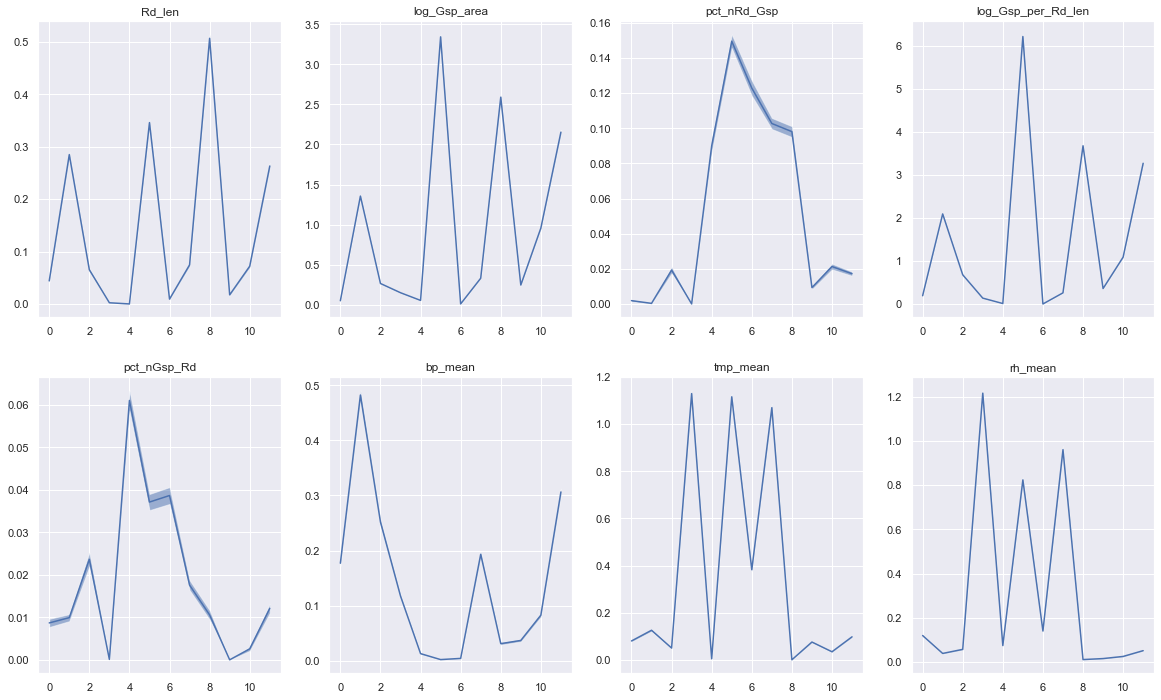

In [33]:
fig, ax = plt.subplots(2,4,figsize=(20,12))
i = 0
for elem in var:
    sns.lineplot(x=range(12), y=m_reg['fi_'+elem].values, ax=ax[i//4,i%4], legend=True)
    ax[i//4,i%4].set_title(elem)
    ax[i//4,i%4].fill_between(x=range(12), y1=m_reg['fi_'+elem].values-m_reg['fi_std_'+elem].values,
                              y2=m_reg['fi_'+elem].values+m_reg['fi_std_'+elem].values, alpha=.5)
    i+=1
plt.show()

In [ ]:
df.groupby('month').mean()['Value'].plot()

In [ ]:
df.info()

In [ ]:
high_period = df[df['month'].isin([1, 2, 3, 4])].drop(['geometry','hour','dayofweek','dayofmonth','month'],axis=1)
low_period = df[~df['month'].isin([1, 2, 3, 4])].drop(['geometry','hour','dayofweek','dayofmonth','month'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

In [ ]:
hp_X = high_period[var].values
hp_y = high_period['Value'].values
reg.fit(hp_X, hp_y)

get_importance(reg, hp_X, hp_y, feature_names=var)

In [ ]:
get_cv_score(reg, hp_X, hp_y)

In [ ]:
reg.coef_.tolist() + [reg.intercept_]

In [ ]:
lp_X = low_period[var].values
lp_y = low_period['Value'].values
reg.fit(lp_X, lp_y)

get_importance(reg, lp_X, lp_y, feature_names=var)

In [ ]:
get_cv_score(reg, lp_X, lp_y)

In [ ]:
reg.coef_.tolist() + [reg.intercept_]

# Mean analysis

In [ ]:
hmean_df = df.groupby(['hour','Site']).mean()
hmean_df.info()

In [ ]:
hmean_df.drop(['bp_mean','tmp_mean','rh_mean','dayofweek','dayofmonth'],axis=1,inplace=True)

In [ ]:
hmean_df.hist()

In [ ]:
sns.heatmap(hmean_df[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
def get_corr(df,iter_range,method='pearson',features=exp_names,target='Value'):
    result=[]
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [ ]:
def get_moran(df,iter_range,w=weight,target='Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [ ]:
def get_reg_info(df,iter_range,features=exp_names,target='Value',reg=LinearRegression()):
    result=[]
    for index in iter_range:
        x=df.loc[(index,),features].values
        #x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
        
        y=df.loc[(index,),target].values
        #y=(y-np.mean(y,axis=0))/np.std(y,axis=0)
        
        reg.fit(x,y)
        coef=reg.coef_.tolist()
        coef.append(reg.score(x,y))
        result.append(coef)
    result=pd.DataFrame(result,columns=features+['score'])
    return result

In [ ]:
hmean_corr=get_corr(hmean_df,range(24))
sns.lineplot(data=hmean_corr,legend=False)
plt.legend(labels=exp_names)
plt.show()

In [ ]:
hmean_corr_sp=get_corr(hmean_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=exp_names)
plt.show()

In [ ]:
hmean_moran=get_moran(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

In [ ]:
hmean_reg=get_reg_info(hmean_df,range(24))
sns.lineplot(x=range(24),y=hmean_reg['score'])

In [ ]:
# plot monthly mean
df.groupby('month').mean()['Value'].plot()

In [ ]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

In [ ]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=exp_names,loc='upper left')
plt.show()

In [ ]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=exp_names,loc='upper left')
plt.show()

In [ ]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

In [ ]:
mmean_reg=get_reg_info(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_reg['score'])

In [ ]:
# identify high period and low period
high=df[df['month'].isin([1,2,3,4])].groupby('Site').mean()
low=df[~df['month'].isin([1,2,3,4])].groupby('Site').mean()

print('high: '+str(high.shape)+'\nlow: '+str(low.shape))

In [ ]:
sns.heatmap(high[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
high_moran=Moran(high['Value'].values,weight)
round(high_moran.I,5)

In [ ]:
reg_high=LinearRegression()
y_high = high['Value'].values
x_high = high[exp_names].values
reg_high.fit(x_high, y_high)
reg_high.score(x_high,y_high)

In [ ]:
prd_high = reg_high.predict(x_high)

r = stats.pearsonr(y_high, prd_high)[0]
r2 = r**2
t, p_value = stats.kendalltau(y_high, prd_high)
print('r2 (obs): ', round(r2, 5))
print('tau (obs): ', round(t, 5))

In [ ]:
cv_r2_high = []
cv_tau_high = []

for i in range(100):
    kf = KFold(n_splits=4, shuffle=True, random_state=i)
    cvprd_high = cross_val_predict(reg_high, x_high, y_high, cv=kf)  #predict using current random folds
    
    #correlations
    r = stats.pearsonr(y_high,cvprd_high)[0]
    t, p_value = stats.kendalltau(y_high, prd_high)
    
    #append to list
    cv_r2_high.append(r**2)
    cv_tau_high.append(t)

print('r2 (cv): ', round(np.mean(cv_r2_high), 5))
print('tau (cv): ', round(np.mean(cv_tau_high),5))
print('r2 variance (cv): ', 1.96 * np.var(cv_r2_high))
print('tau variance (cv): ', 1.96 * np.var(cv_tau_high))

In [ ]:
sns.heatmap(low[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
low_moran=Moran(low['Value'].values,weight)
round(low_moran.I,5)

In [ ]:
reg_low = LinearRegression()
y_low = low['Value'].values
x_low = low[exp_names].values
reg_low.fit(x_low, y_low)
prd_low = reg_low.predict(x_low)

r = low['Value'].corr(pd.Series(prd_low))
r2 = r**2
t = low['Value'].corr(pd.Series(prd_low), method='kendall')
print("r2 (cv): ", round(r2,3))   
print("tau (cv): ", round(t,3))

In [ ]:
sns.heatmap(all[['Value']+exp_names].corr().round(4),annot=True,fmt='.4f',cmap='magma')
plt.show()

In [ ]:
all=df.groupby('Site').mean()
all_moran=Moran(all['Value'].values,weight)
round(all_moran.I,5)

In [ ]:
y_all=(all.groupby('Site').mean()['Value'].values)
x_all=(all.groupby('Site').mean()[exp_names].values)

reg.fit(x_all,y_all)
reg.score(x_all,y_all)